In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import csv
from functools import partial

ERROR 1: PROJ: proj_create_from_database: Open of /glade/work/lgetker/conda-envs/my-clone/share/proj failed


In [2]:
"""
Data user settings
"""

# Select a pressure level
p_level = 500

# Select a variable U, V, W, S, H, Z, T, R, or Q.
var = "Z"

# Name of .csv file directory with dates in yyyymmdd format. Only used if readCSV = 1
csv_name = "/glade/u/home/lgetker/hw_detection/98_200000km_hws_dates.npy"  

# Westernmost longitude for subsetting. Choose -180 to 180
wlon = 360-180

# Easternmost latitude for subsetting. Choose -180 to 180
elon = 360-40

# Southernmost latitude for subsetting. Choose -90 to 90
slat = 10

# Northernmost latitude for subsetting.Choose -90 to 90
nlat = 75

# The map projection you would like to use. You may need to change the central longitude depending on domain
projection = ccrs.Mercator(central_longitude = 0)

"""
SOM User settings
"""
# SOM rows
rows = 4

# SOM columns
cols = 4

"""
Constants
"""
# acceleration of gravity for geopotential conversion
g0 = 9.80665

# for converting longitudes
l0 = 360 

# ERAI means path
era5_path = "/glade/campaign/collections/rda/data/ds633.0/e5.oper.an.pl/"

"""Error messages"""
coord_error = "Coordinates out of bounds."

In [3]:
"""
Get dates from np file
"""
pd_dates = []
# with open(csv_name) as f:
#     r = csv.reader(f, delimiter=",")
#     for i, data in enumerate(r):
#         if i == 0:
#             continue
#         pd_dates.append(pd.Timestamp(data[1]))
# print(len(pd_dates))
dates = np.load(csv_name, allow_pickle = True)
for i in dates:
    pd_dates.append(pd.Timestamp(i))
    
print(len(pd_dates))
datafiles = []
for i in range(len(pd_dates)):
    year = str(pd_dates[i].year)
    month = pd_dates[i].month
    if month < 10:
        month = '0' + str(month)
    else:
        month = str(month)
    day = pd_dates[i].day
    if day < 10:
        day = '0' + str(day)
    else:
        day = str(day)
    filename = era5_path + year + month + "/e5.oper.an.pl.128_129_z.ll025sc." + year + month + day +"00_" + year + month + day + "23.nc"
    #print(filename)
    datafiles.append(filename)

"""
Input mean file
"""
mean_ds = xr.open_dataset("/glade/work/lgetker/500mb_height_mean.nc")
mean_dates = mean_ds['time'].values

461


In [4]:
def _preprocess(x):
    x = x.sel(level=p_level)
    return x.where((x['latitude'] < nlat) & (x['latitude'] > slat) & (x['longitude'] > wlon) & (x['longitude'] < elon), drop=True)

In [5]:
partial_func = partial(_preprocess)
ds = xr.open_mfdataset(datafiles, preprocess=partial_func)

In [6]:
dscat_list = []
for i in range(len(pd_dates)):
    print(i)
    ds_sub = ds.sel(time=pd_dates[i])
    month = pd_dates[i].month
    day = pd_dates[i].day
    generic_time = pd.Timestamp(year=2000, month=month, day=day) # Means are saved with a "dummy" time of 2000
    mean_day = mean_ds.sel(time=generic_time)['500mb_mean'].values
    variable = ds_sub[var].values
    if var == 'Z':  # convert geopotential to geopoential height if necessary
        variable = variable / g0
    variable = np.subtract(variable, mean_day)
    dscat_list.append(variable)
#dscat = xr.concat(dscat_list,dim='time')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [7]:
print(len(dscat_list))
lats = ds['latitude'].values
lons = ds['longitude'].values
da = xr.DataArray(dscat_list, coords=[pd_dates, lats, lons], dims=['time', 'lat', 'lon'])
#Subset the data.
da_sub = da.where((da['lat']<nlat) & (da['lat']>slat) &  (da['lon']>wlon) & (da['lon']<elon), drop = True)

#redefine lats and lons after subsetting.
lats = da_sub['lat'].values
lons = da_sub['lon'].values
print(da_sub)

461
<xarray.DataArray (time: 461, lat: 259, lon: 559)>
array([[[  -3.54638672,   -2.48632812,   -1.44384766, ...,
           24.52148438,   25.90234375,   27.28564453],
        [  -6.94384766,   -5.85644531,   -4.80957031, ...,
           26.65966797,   28.01611328,   29.36767578],
        [ -10.31298828,   -9.21777344,   -8.13671875, ...,
           28.78662109,   30.09423828,   31.41552734],
        ...,
        [ -11.55371094,  -12.46679688,  -13.59570312, ...,
           -8.57714844,   -8.35009766,   -8.06689453],
        [ -12.05273438,  -12.90917969,  -13.83251953, ...,
           -8.92626953,   -8.70605469,   -8.38085938],
        [ -12.48095703,  -13.16796875,  -13.78564453, ...,
           -9.22753906,   -8.97119141,   -8.67382812]],

       [[ -24.67871094,  -23.54199219,  -22.37451172, ...,
           82.28955078,   82.40820312,   82.50488281],
        [ -28.56152344,  -27.49902344,  -26.42919922, ...,
           81.51171875,   81.60449219,   81.69628906],
        [ -32.1630

In [8]:
# #fixing the oopsie
# mean_ds = xr.open_dataset("500mb_height_mean.nc")
# times = da_sub['time'].values
# for i in range(len(times)):
#     pd_time = pd.Timestamp(times[i])
#     month = pd_time.month
#     day = pd_time.day
#     if day == 31 and month == 8:
#         generic_time = pd.Timestamp(year=2000, month=month, day=day) # Means are saved with a "dummy" time of 2000
#         mean_day = mean_ds.sel(time=generic_time)['500mb_mean'].values
#         da_sub[i,:,:] = np.subtract(da_sub[i,:,:], mean_day)

In [20]:

from itertools import product
from minisom import MiniSom, asymptotic_decay
#Number of SOM rows
rows = 3

#Number of SOM columns
cols = 3

#True if you would like composites to be saved
save_som = 0

#Initial learning rate (at the iteration t we have learning_rate(t) = learning_rate / (1 + t/T) where T is #num_iteration/2)
learning_rate = 0.1

#The decay function used.
decay_function = asymptotic_decay

#Neighborhood function
neighborhood_function = 'gaussian'

#Topology of the map; Possible values: 'rectangular', 'hexagonal'
topology = 'rectangular'

#Distance used to activate the map; Possible values: 'euclidean', 'cosine', 'manhattan', 'chebyshev'
activation_distance = 'euclidean' 

#Random seed to use for reproducibility. Using 1.
random_seed = 1

#How many times the SOM should iterate. Was 100000, reduced while experimenting (GL)
num_iteration = 100000

#
random_order = True

#
verbose = True

# Spread of the neighborhood function, needs to be adequate to the dimensions of the map.
sigma = 2.3

"""
Function for normalizing data prior to training using z-score (MM)
param data: the data
returns: the normalized data.
"""
def normalize_data(data):
    return (data - np.nanmean(data)) / np.nanstd(data)

"""
format data and train SOM
"""
data = da_sub.values
nt, ny, nx = data.shape
subset = da_sub.stack(new=("lat","lon"))

# if array looks good, assign to numpy array object
subsetarray = subset.values
input_length = subsetarray.shape[1] 
som = MiniSom(
                rows,
                cols,
                input_length,
                sigma,
                learning_rate,
                decay_function,
                neighborhood_function,
                topology,
                activation_distance,
                random_seed)

data = normalize_data(subsetarray)
som.random_weights_init(data)    # random method

som.train(
        data,
        num_iteration,
        random_order,
        verbose)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 335.4795469699514


In [21]:
# import pickle
# with open('som_hw_dates.p', 'wb') as outfile:
#     pickle.dump(som, outfile)
# da_sub.to_netcdf(path="hw_data.nc")

Topographic error: 0.010845986984815618


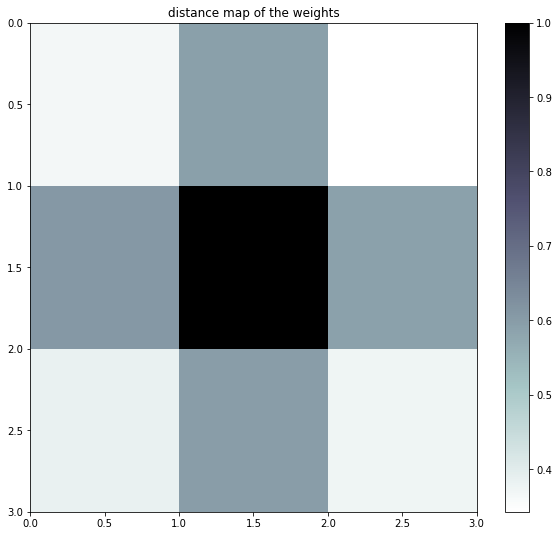

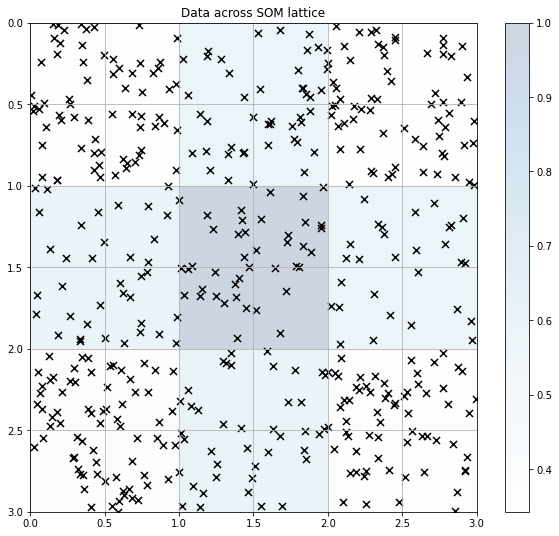

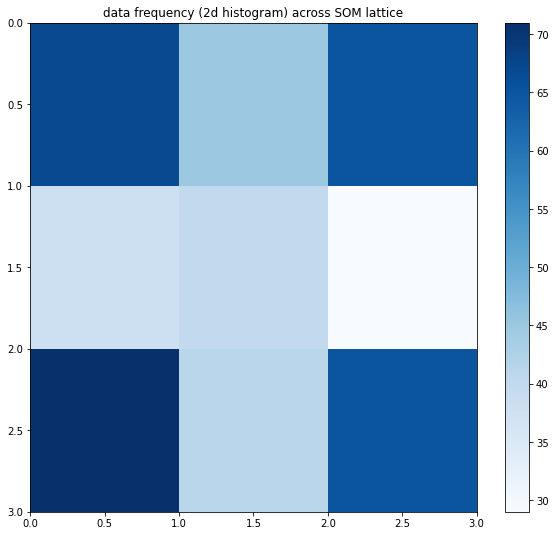

In [22]:
"""
This plot shows the SOM lattice's distance map of weights.
Each cell is the normalised sum of the distances between
a neuron and its neighbours. Note that this method uses
the euclidean distance.
"""

plt.figure(figsize=(10, 9))
cs = plt.pcolormesh(som.distance_map(), cmap='bone_r')
plt.title("distance map of the weights", fontsize=12)
plt.colorbar(cs)
plt.ylim(rows, 0)  # flip the y axis to be the same as composite map axes later
plt.savefig("distance_map.png")


"""
This plot shows how cases are distributed across the SOM nodes. 
The markers are randomly plotted across each node.
"""

# grab the x and y coords across the lattice for the winner node for each data point
w_x, w_y = zip(*[som.winner(d) for d in data])
w_x = np.array(w_x)
w_y = np.array(w_y)
# visualize where data falls in lattice (nearest winning neuron/node)
plt.figure(figsize=(10, 9))
plt.pcolormesh(som.distance_map(), cmap='Blues', alpha=.2)
plt.colorbar()

for num, c in enumerate(w_x[::1]):     # every 20th data point
    plt.scatter(w_y[num] + np.random.rand(1),   # add a random decimal to prevent overlapping of markers
                w_x[num] + np.random.rand(1),
                s=50, c='k', marker='x')

plt.title("Data across SOM lattice", fontsize=12)
plt.margins(x=0,y=0)
plt.grid()
plt.ylim(rows, 0)  # flip the y axis to be the same as composite map axes later


"""
This plot shows distribution across the lattice.
"""

plt.figure(figsize=(10, 9))
frequencies = som.activation_response(data)
plt.pcolormesh(frequencies, cmap='Blues') 
plt.colorbar()
plt.title("data frequency (2d histogram) across SOM lattice", fontsize=12)
plt.ylim(rows, 0)  # flip the y axis to be the same as composite map axes later
plt.savefig("distribution.png", bbox_inches = 'tight')


"""
After the SOM is trained, we want to know which cases are associated which each SOM node.
These values are stored in winmap[x,y], where x is the SOM row and y is the SOM column.
"""

# create an empty dictionary using the rows and columns of SOM
keys = [i for i in product(range(rows),range(cols))]
winmap = {key: [] for key in keys}

# grab the indices for the data within the SOM lattice
for i, x in enumerate(data):
    winmap[som.winner(x)].append(i)

# create list of the dictionary keys
som_keys = list(winmap.keys())


print("Topographic error: " + str(som.topographic_error(data)))

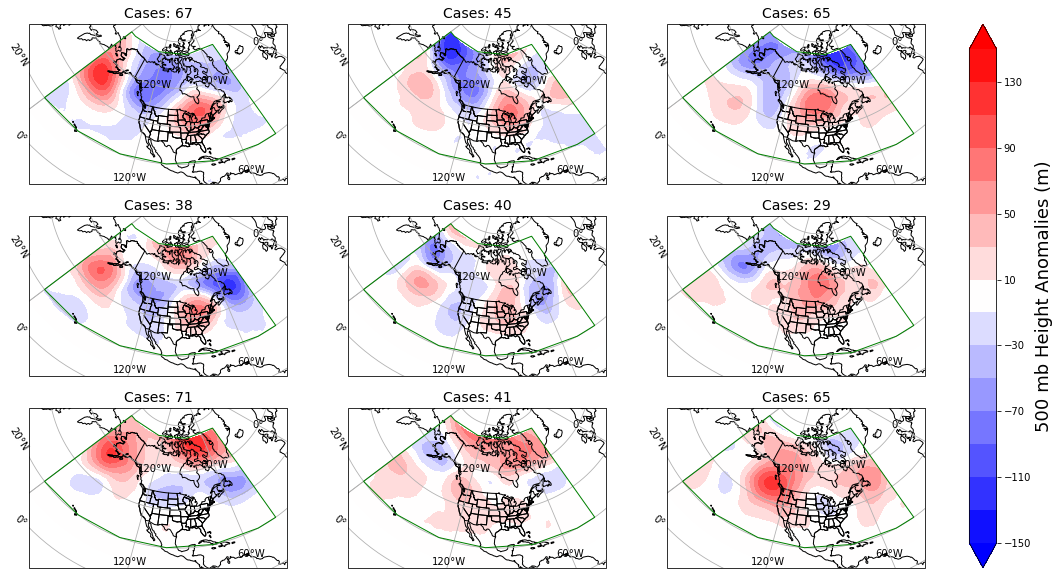

In [84]:
"""
Visualization. You'll want to change some things here, such as plot titles, contour levels, and map extent!
"""
projection = ccrs.LambertConformal()
import matplotlib.patches as mpatches
fig, axs = plt.subplots(rows, cols, subplot_kw={'projection': projection}, figsize=(20,10))  #Fig size may need to be changed to look nice.
mapnum = 0 
#Loop through each SOM node
for x in range(0,rows):
    for y in range(0,cols):
        data = subset[np.array(winmap[som_keys[mapnum]])].unstack().mean(dim="time",skipna=True)
        cases = winmap[som_keys[mapnum]]
        #axs[x,y].set_extent([elon,wlon,slat,nlat],crs=ccrs.PlateCarree())  #subset to a specific region
        axs[x,y].add_feature(cfeature.STATES, edgecolor='black')  #Add US states
        axs[x,y].add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
        gl = axs[x,y].gridlines(draw_labels=True, dms=True)
        gl.top_labels=False   # suppress top grid labels
        gl.right_labels=False # suppress right grid labels
       #axs[x,y].set_title(str(x) + " " + str(y))  #set title
        axs[x,y].set_title("Cases: " + str(len(cases)), fontsize = 14)
        axs[x,y].add_patch(mpatches.Rectangle(xy=[180, 20], width=140, height=55,
                                facecolor='none', edgecolor='g',zorder=10,
                                transform=ccrs.PlateCarree()))
        # axs[x,y].plot([180, 300], [20, 20],
        #  color='black', linewidth=1, marker='.',
        #  transform=ccrs.Geodetic(), #remove this line to get straight lines
        #  )
        cs = axs[x,y].contourf(lons, lats, data, cmap = 'bwr', transform=ccrs.PlateCarree(), levels = np.arange(-150, 170, 20), extend = 'both')

        mapnum = mapnum + 1

cbar = plt.colorbar(cs,ax=fig.get_axes(), pad=0.04)
cbar.ax.set_ylabel("500 mb Height Anomalies (m)", fontsize = 18)
#cbar.set_label(str(p_level) + " " + var_name, fontsize = 16)

plt.savefig("500_ht_alldates.png", bbox_inches = 'tight')


67
5007.087890625
45
3528.5546875
65
5085.0517578125
38
2897.9873046875
40
3240.94091796875
29
1914.7158203125
71
5147.48291015625
41
3359.7763671875
65
5085.0517578125


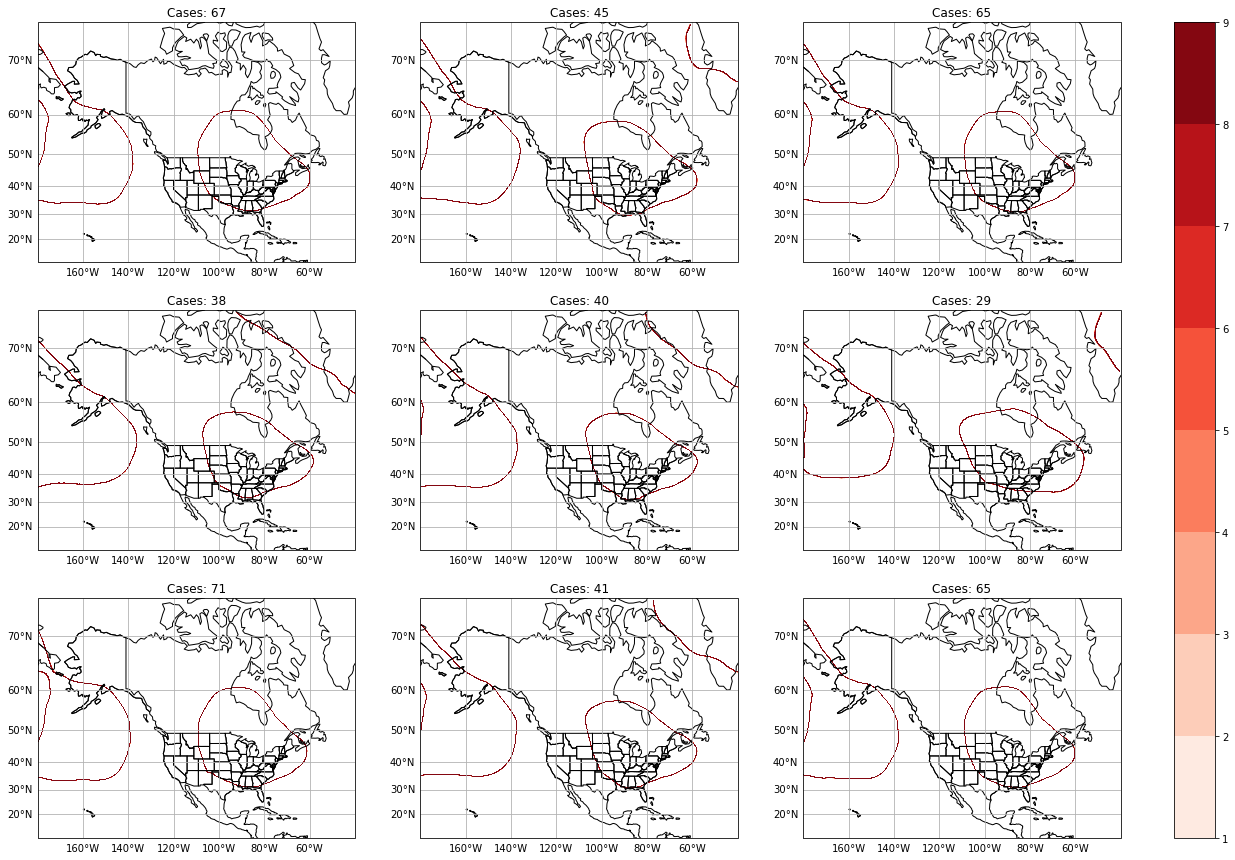

In [24]:
fig, axs = plt.subplots(3, 3, subplot_kw={'projection': ccrs.Mercator(central_longitude = 0)}, figsize=(24,15))  #Fig size may need to be changed to look nice.
mapnum = 0
for x in range(0,3):
    for y in range(0,3):
        node_dates = winmap[som_keys[mapnum]]
        print(len(node_dates))
        node_masks = np.zeros([len(node_dates), 259, 559])
        for i in range(len(node_dates)):
            node_masks[i,:,:] = da_sub[i,:,:]
        freq = np.sum(node_masks, axis = 0)
        print(np.max(freq))
        axs[x,y].set_extent([elon,wlon,slat,nlat],crs=ccrs.PlateCarree())
        axs[x,y].add_feature(cfeature.STATES, edgecolor='black')  #Add US states
        axs[x,y].add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
        gl = axs[x,y].gridlines(draw_labels=True, dms=True)
        gl.top_labels=False   # suppress top grid labels
        gl.right_labels=False # suppress right grid labels
        axs[x,y].set_title(f"Cases: {len(node_dates)}")  #set title
        cs = axs[x,y].contourf(lons, lats, freq, cmap = 'Reds', transform=ccrs.PlateCarree(), levels = np.arange(1,10,1))
        mapnum += 1
cbar = plt.colorbar(cs,ax=fig.get_axes(), pad=0.04)
            

1944-08-03 23:00:00


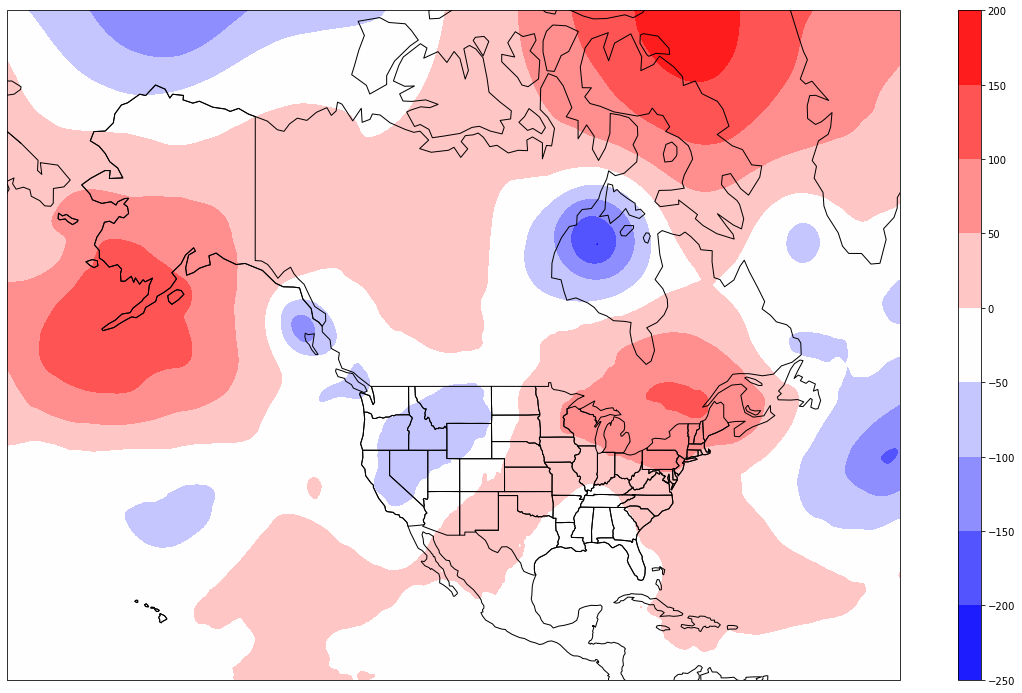

In [25]:
idx = 10
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection=ccrs.Mercator(central_longitude = 0))
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
#ax.set_extent([wlon, elon, slat, nlat], crs=ccrs.PlateCarree())
print(pd_dates[idx])
cs = ax.contourf(lons, lats, da_sub[idx,:,:], cmap = "bwr", transform=ccrs.PlateCarree())
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
plt.colorbar(cs, cax = cax)

In [15]:
print(np.max(da_sub))
print(np.max(mean_ds))

<xarray.DataArray ()>
array(368.02783203)
<xarray.Dataset>
Dimensions:     ()
Data variables:
    500mb_mean  float64 5.927e+03


In [16]:
mean_arr = mean_ds['500mb_mean'].values
mean_dates = mean_ds['time'].values

2000-08-31T00:00:00.000000000


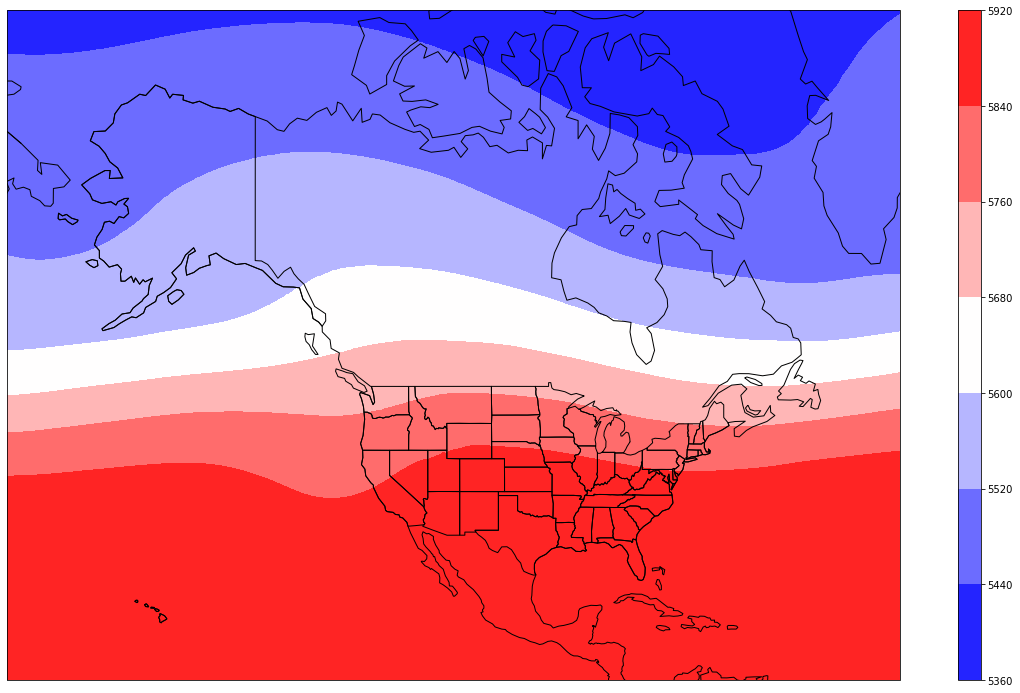

In [17]:
idx = 91
fig = plt.figure(figsize=(16,16))
ax = plt.axes(projection=ccrs.Mercator(central_longitude = 0))
ax.add_feature(cfeature.STATES, edgecolor='black')  #Add US states
ax.add_feature(cfeature.COASTLINE, edgecolor='black')  #Add coastlines
#ax.set_extent([wlon, elon, slat, nlat], crs=ccrs.PlateCarree())
print(mean_dates[idx])
cs = ax.contourf(lons, lats, mean_arr[idx,:,:], cmap = "bwr", transform=ccrs.PlateCarree())
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])  #You can change the numbers to move the colorbar.
plt.colorbar(cs, cax = cax)

In [26]:
mapnum = 0
mean_date = []
all_dates = []
for x in range(0,rows):
    for y in range(0,cols):
        node_dates = []
        print(x,y)
        cases = np.array(winmap[som_keys[mapnum]])
        year_sum = 0
        for i in range(len(cases)):
            year_sum += int(pd_dates[cases[i]].year)
            node_dates.append(pd_dates[cases[i]])
        node_dates_np = np.array(node_dates)
        np.save("node_" + str(x) + "_" + str(y) + "_dates",node_dates_np)
        mean_date.append(year_sum / len(cases))
        mapnum +=1
print(mean_date)

0 0
0 1
0 2
1 0
1 1
1 2
2 0
2 1
2 2
[1979.0746268656717, 1995.2444444444445, 1985.676923076923, 1990.921052631579, 1995.975, 1998.448275862069, 2003.1690140845071, 2008.560975609756, 2011.7692307692307]
